In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,average_precision_score, accuracy_score, roc_auc_score,roc_curve, auc,precision_recall_curve


# Exercise 2:

<b>Consider a hospital that needs to prioritize which patients to take in. They have the following dataset of past patients that came into their ER feeling ill. This dataset includes the outcomes in the absence of further treatment as well as other information known about the patient.

In the past the hospital did not have a cardiology department. However, they just received a new grant from the Ministry of Health to establish a cardiology department (as part of the government's initiative to bring AI to hospitals). Create a model that predicts whether, without treatment, a patient will die in the next six months.</b>

In [2]:
survival_history_matrix = pd.read_csv('./Data for metrics exercise/features_churn_matrix_ex2.csv')
survival_history_matrix.head()

,is_male,num_prev_internations,has_genetic_marker_1,has_genetic_marker_2,age,BMI,history_family_of_heart_disease,died_within_6_months
0,False,1.0,False,True,52.0,32.0,False,False
1,True,0.0,False,False,58.0,27.0,False,True
2,True,1.0,False,True,61.0,31.0,True,False
3,True,0.0,False,True,55.0,31.0,True,False
4,True,2.0,False,True,62.0,21.0,False,False


Let's see some statistics

In [3]:
survival_history_matrix.shape

(200000, 8)

In [4]:
survival_history_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   is_male                          200000 non-null  bool   
 1   num_prev_internations            200000 non-null  float64
 2   has_genetic_marker_1             200000 non-null  bool   
 3   has_genetic_marker_2             200000 non-null  bool   
 4   age                              200000 non-null  float64
 5   BMI                              200000 non-null  float64
 6   history_family_of_heart_disease  200000 non-null  bool   
 7   died_within_6_months             200000 non-null  bool   
dtypes: bool(5), float64(3)
memory usage: 5.5 MB


we have float's and bool's values in our data set, let's inplace bool values with  numbers

In [5]:
survival_history_matrix[['is_male', 'has_genetic_marker_1', 'has_genetic_marker_2','history_family_of_heart_disease', 'died_within_6_months']] = \
survival_history_matrix[['is_male', 'has_genetic_marker_1', 'has_genetic_marker_2','history_family_of_heart_disease', 'died_within_6_months']].astype(int)

It's good to check  on numerical vs categorical data ( is there left smthng except froat's values)

In [6]:
numerical_columns = survival_history_matrix.describe().columns

categorical_columns = survival_history_matrix.dtypes[survival_history_matrix.dtypes == bool].index.tolist()

print('continious features: {}'.format(numerical_columns))
print('\ncategorical features: {}'.format(categorical_columns))

continious features: Index(['is_male', 'num_prev_internations', 'has_genetic_marker_1',
       'has_genetic_marker_2', 'age', 'BMI', 'history_family_of_heart_disease',
       'died_within_6_months'],
      dtype='object')

categorical features: []


Great. Let's continue and check for NAN values

In [7]:
survival_history_matrix.isna().sum()

is_male                            0
num_prev_internations              0
has_genetic_marker_1               0
has_genetic_marker_2               0
age                                0
BMI                                0
history_family_of_heart_disease    0
died_within_6_months               0
dtype: int64

We can see: there are non NAN's in our data, which is great

In [8]:
survival_history_matrix.describe()

,is_male,num_prev_internations,has_genetic_marker_1,has_genetic_marker_2,age,BMI,history_family_of_heart_disease,died_within_6_months
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.598905,0.550520,0.100055,0.300375,59.989505,29.995980,0.299435,0.143145
std,0.490121,0.583463,0.300074,0.458422,4.998340,5.008023,0.458012,0.350222
min,0.000000,0.000000,0.000000,0.000000,38.000000,9.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,57.000000,27.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,60.000000,30.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,63.000000,33.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,1.000000,81.000000,56.000000,1.000000,1.000000


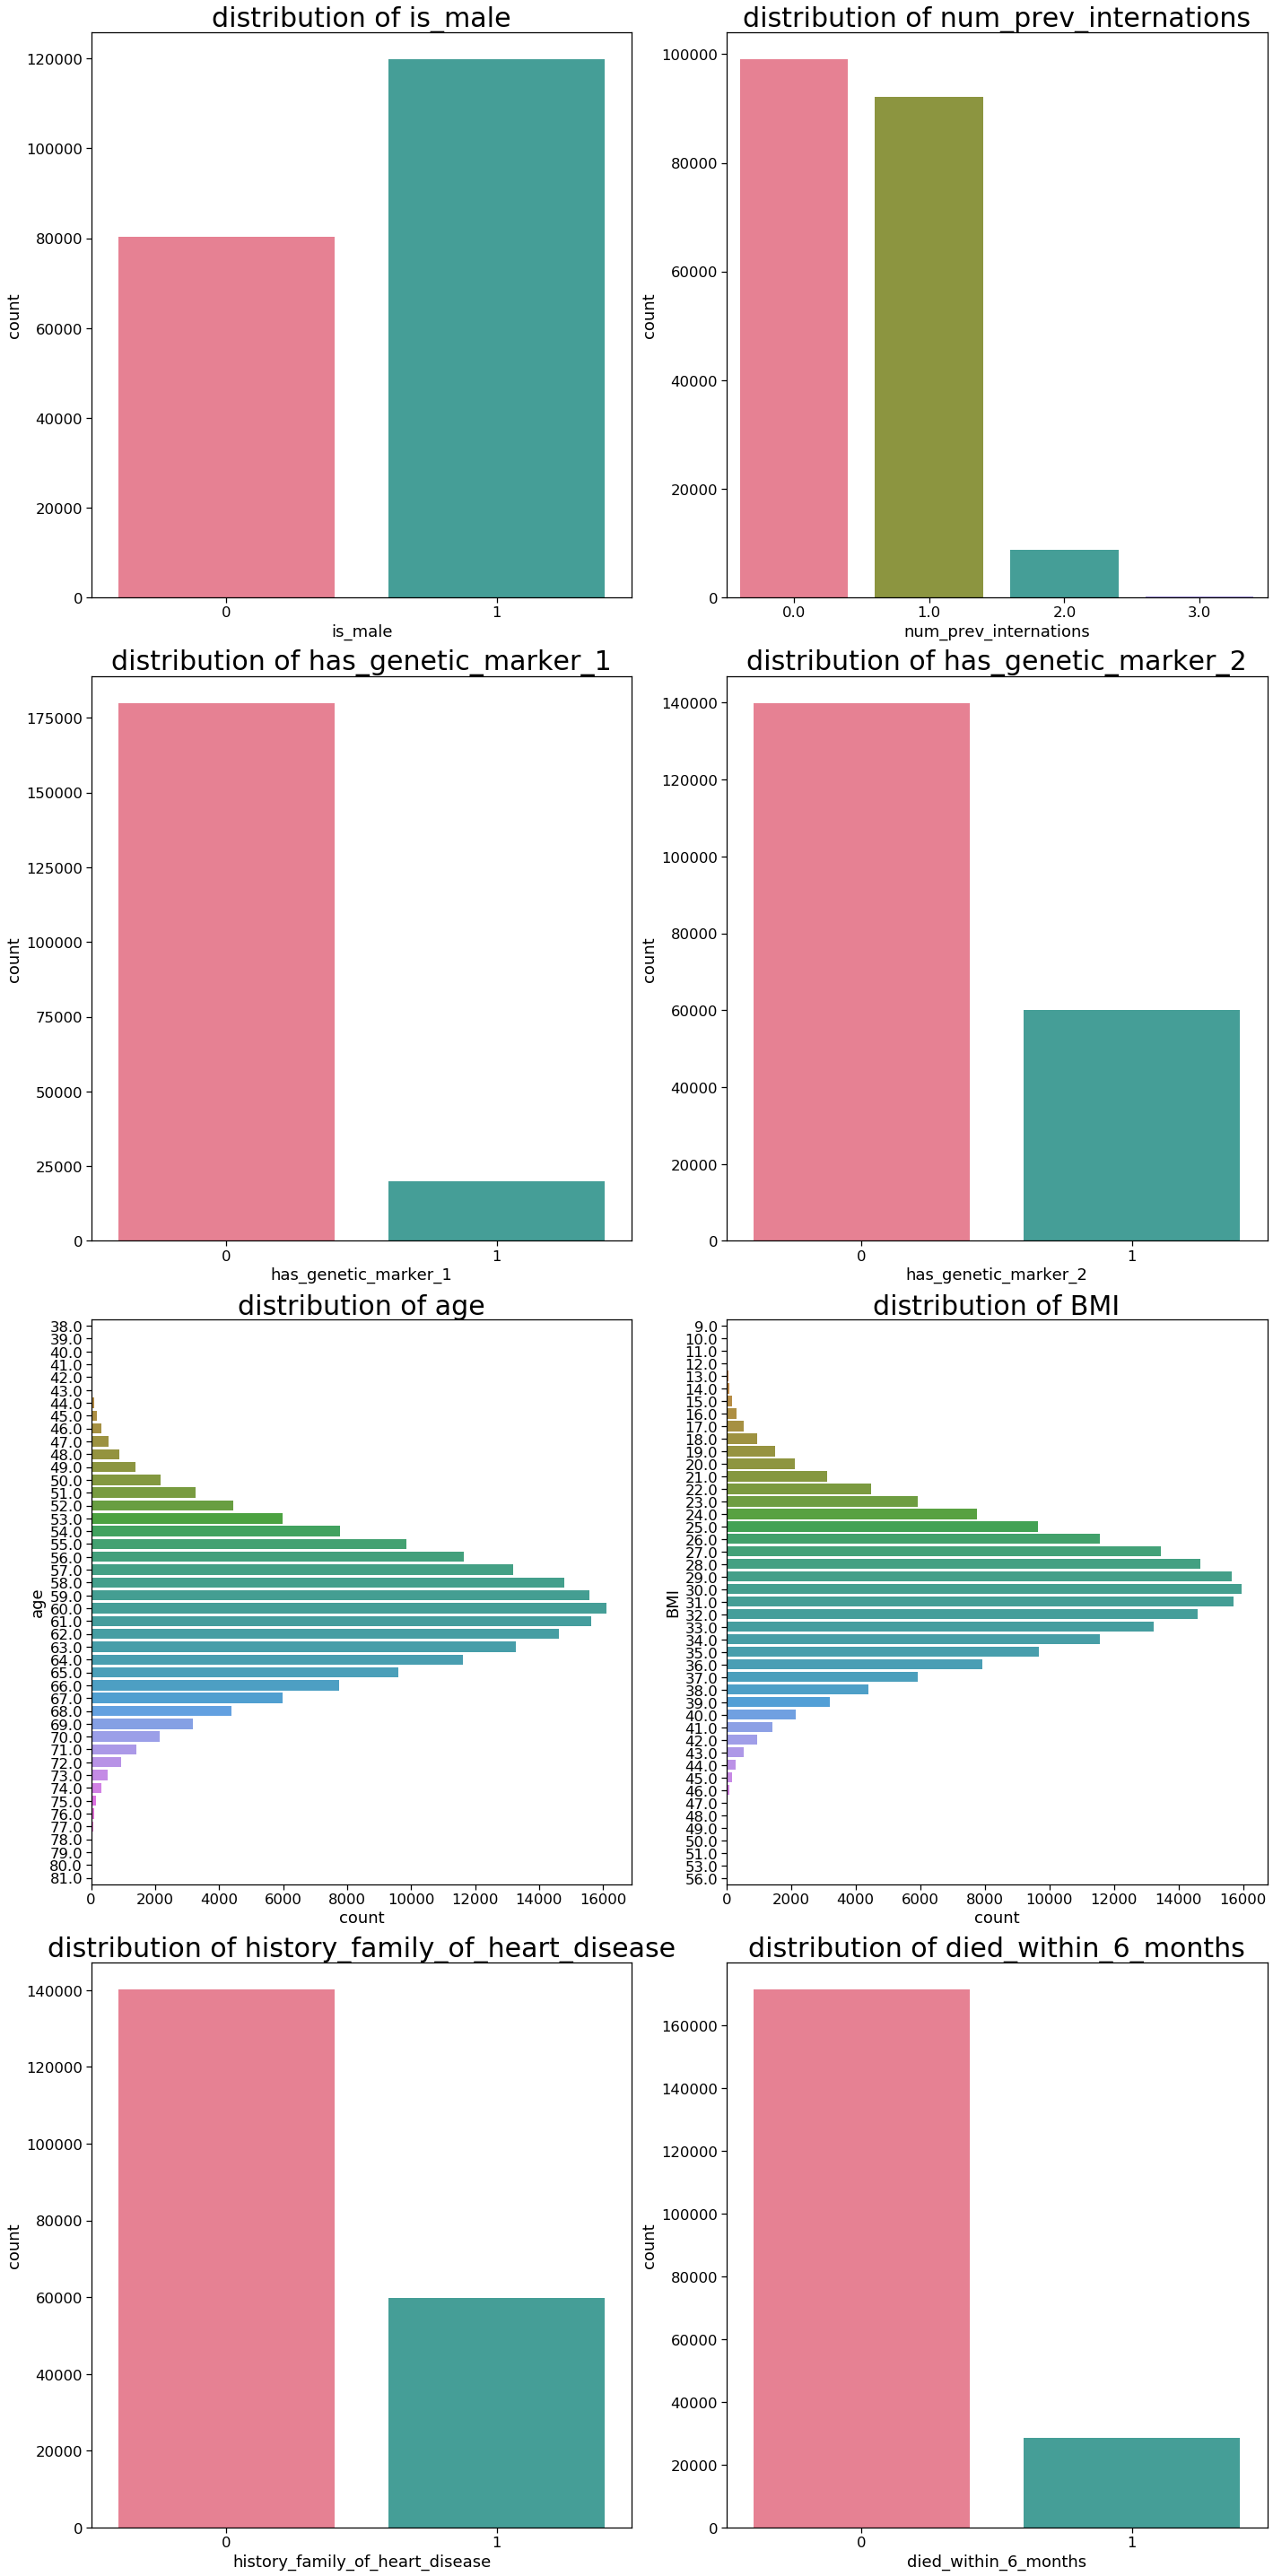

In [9]:
plt.figure(figsize=(20,40))
for i,col in enumerate(numerical_columns):
    plt.subplot(4,2,i+1)
    plt.tight_layout()
    plt.title(f'distribution of {col}', fontsize=30)
    if col in('age','BMI'):
        sns.countplot(y=col, palette="husl", data=survival_history_matrix)
    else:
        sns.countplot(x=col, palette="husl", data=survival_history_matrix)

In [10]:
survival_history_matrix['num_prev_internations'].value_counts()/len(survival_history_matrix)*100

0.0    49.504
1.0    46.033
2.0     4.370
3.0     0.093
Name: num_prev_internations, dtype: float64

Well, i guess we should union in num_prev_internations values categories 2 and 3 into category 2 only because they all together will be about 4.5% of all column values and this new category will have the meaning 2 and more times

In [11]:
survival_history_matrix['num_prev_internations'] =\
    survival_history_matrix['num_prev_internations'].replace({3.0:2.0})

In [12]:
survival_history_matrix['num_prev_internations'].value_counts()/len(survival_history_matrix)*100

0.0    49.504
1.0    46.033
2.0     4.463
Name: num_prev_internations, dtype: float64

Let's now check for outliers `age` and `BMI`

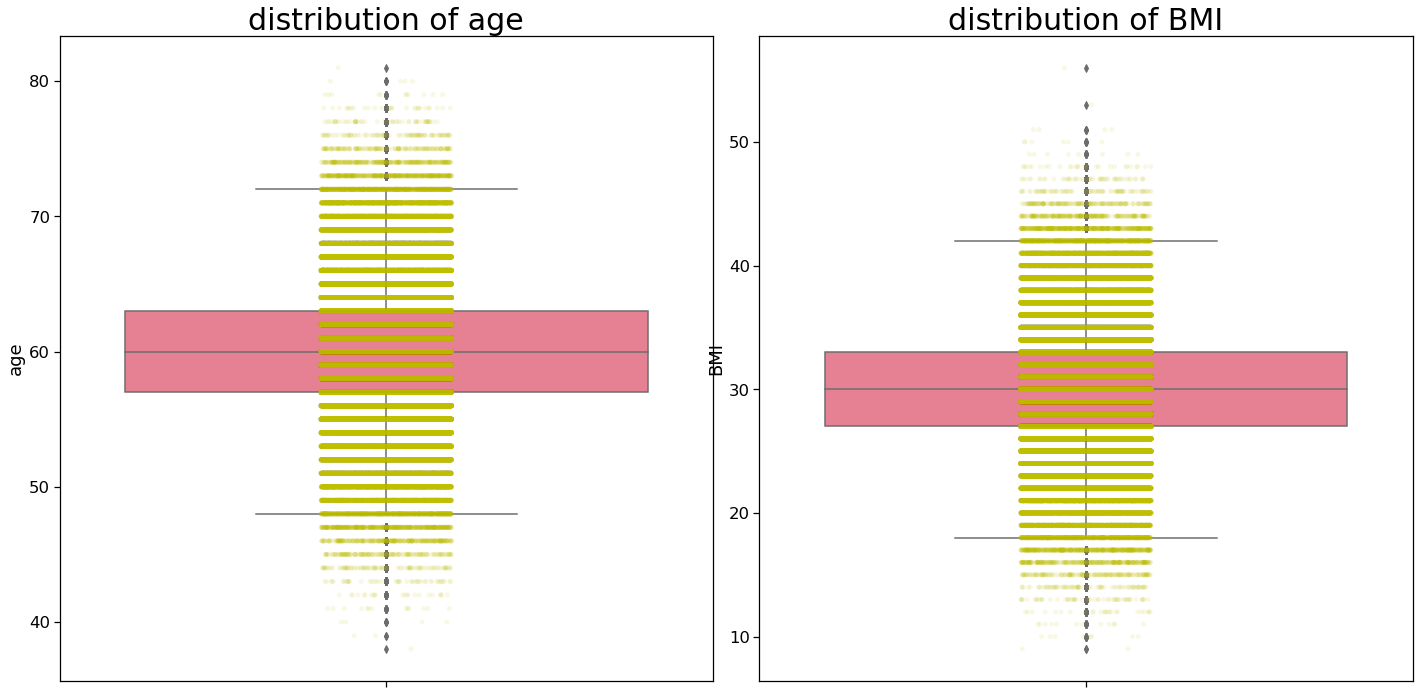

In [13]:
plt.figure(figsize=(20,10))
for i,col in enumerate(['age','BMI']):
    plt.subplot(1,2, i+1)
    plt.tight_layout()
    plt.title(f'distribution of {col}', fontsize=30)
    sns.boxplot(y=col, palette="husl", data=survival_history_matrix)
    sns.stripplot(y=col, data=survival_history_matrix, color='y',alpha=0.1)

We can continue some preproceccing and leave outliers in these two features

But let's see how balanced the data is

In [14]:
survival_history_matrix.died_within_6_months.value_counts()/len(survival_history_matrix)

0    0.856855
1    0.143145
Name: died_within_6_months, dtype: float64

Not very good - the data is imbalanced. Well, We can balance it: to take all the TRUE values and randomly pick the same number of FALSE.

In [15]:
# Shuffle the Dataset.
shuffled_df = survival_history_matrix.sample(frac = 1, random_state = 42)

# Put all the died_within_6_months class in a separate dataset.
died_within_6_months = shuffled_df.loc[shuffled_df.died_within_6_months == 1]

#Randomly select 28629 observations from the `non-dead`(majority class)
not_died_within_6_months = shuffled_df.loc[shuffled_df["died_within_6_months"] == 0].\
            sample(n = died_within_6_months.shape[0],random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([died_within_6_months, not_died_within_6_months])

In [16]:
normalized_df.died_within_6_months.value_counts()/len(normalized_df)

1    0.5
0    0.5
Name: died_within_6_months, dtype: float64

Good result, we can continue now

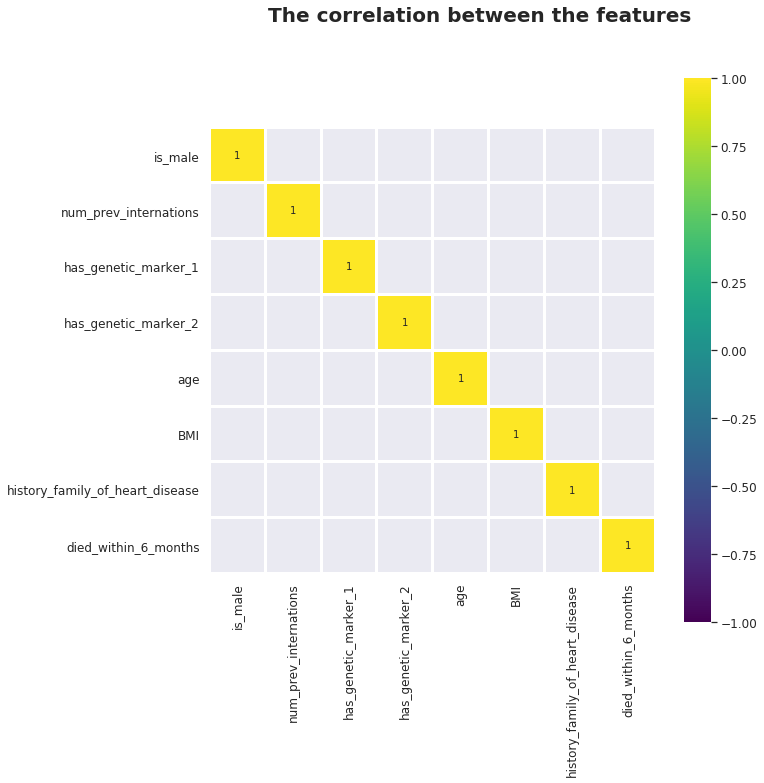

In [17]:
corr = survival_history_matrix.corr()
f = plt.figure(figsize=(10, 10))

sns.set(font_scale=1.1)
sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=2,
            annot=True, annot_kws={"size": 10}, square=True)
f.suptitle('The correlation between the features',fontsize=20, fontweight='bold')
plt.show()

And nothing weird for now with our data, no any visible correlation

In [18]:
features = ['is_male', 'num_prev_internations', 'has_genetic_marker_1',
       'has_genetic_marker_2', 'age', 'BMI', 'history_family_of_heart_disease']            
target ='died_within_6_months'

**Our business question:** Predicting whether without treatment, a patient will die in the next six months. Therefore our dependent variable is the `died_within_6_months` 

Now it's time to Split data to train and test

In [19]:
rel_data = normalized_df[features + [target]]
X = rel_data[features]
y = rel_data[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Splited  dataset into a 2 sets:',
      '\nTrain set is:', round(len(X_train)/len(rel_data),1), '%'\
      '\nTest set is:', round(len(X_test)/len(rel_data), 1), '%')

Splited  dataset into a 2 sets: 
Train set is: 0.8 %
Test set is: 0.2 %


What about shape?

In [21]:
X_train.shape[0], X_test.shape[0],y_train.shape[0], y_test.shape[0]

(45806, 11452, 45806, 11452)

Let's check the proportion of spliting

In [22]:
pd.Series(y_train).value_counts()/len(y_train)


0    0.500895
1    0.499105
Name: died_within_6_months, dtype: float64

In [23]:
pd.Series(y_test).value_counts()/len(y_test)


1    0.50358
0    0.49642
Name: died_within_6_months, dtype: float64

In [24]:
rel_data.died_within_6_months.value_counts()/len(rel_data)


1    0.5
0    0.5
Name: died_within_6_months, dtype: float64

Everything is ok. Now we will fit our model

In [25]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

# fit the tree
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [26]:
y_pred_tree = clf_tree.predict(X_test)

## 2A
**What's the accuracy and average precision of your model?**

In [27]:
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score

print (f"Accuracy clf_tree Score : {accuracy_score(y_test, y_pred_tree)}\n")
print (f"Average clf_tree Precision: {average_precision_score(y_test, clf_tree.predict_proba(X_test)[:, 1])}")

Accuracy clf_tree Score : 0.6081907090464548

Average clf_tree Precision: 0.6244279534217999


Let's Print the confusion matrix

In [28]:
def draw_confusionmatrix(ytest, yhat):
    plt.figure(figsize=(7,5))
    cm = confusion_matrix(ytest, yhat)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 13},fmt="d", cmap=plt.cm.cividis)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix of classifier')

    acc = accuracy_score(ytest, yhat)
    print(f"Sum Axis-1 as Total Accuracy: {acc}")

Sum Axis-1 as Total Accuracy: 0.6081907090464548


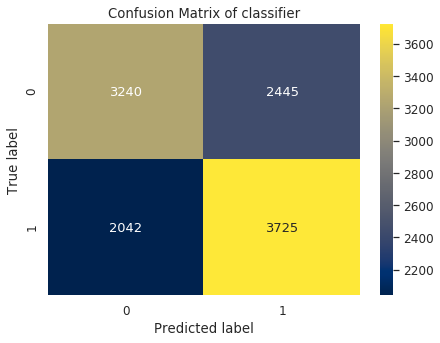

In [29]:
draw_confusionmatrix(y_test, y_pred_tree)

In [30]:
report = classification_report(y_test, y_pred_tree)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.57      0.59      5685
           1       0.60      0.65      0.62      5767

    accuracy                           0.61     11452
   macro avg       0.61      0.61      0.61     11452
weighted avg       0.61      0.61      0.61     11452



## 2B

**A week into the project, you still don't really know what the Head of Department wants from this project and exactly how it will be used. How would you describe your progress and metrics about the model to the Head of Department in 1 minute.**

**Please write down a sentence or two explaining why you picked that metric**

Well, at first i descided to take accuracy because it's simple to explain to  the Head of Department in 1 minute. But the value of that metric is not so representative: we will be correct in our prediction only in 60,59% cases
<br>But now i guess we ahve to take the precision/recall metrics and display the AUC-ROC Curve and the PR Curve to see better our model's behavior

## 2C

**Plot the PR Curve**

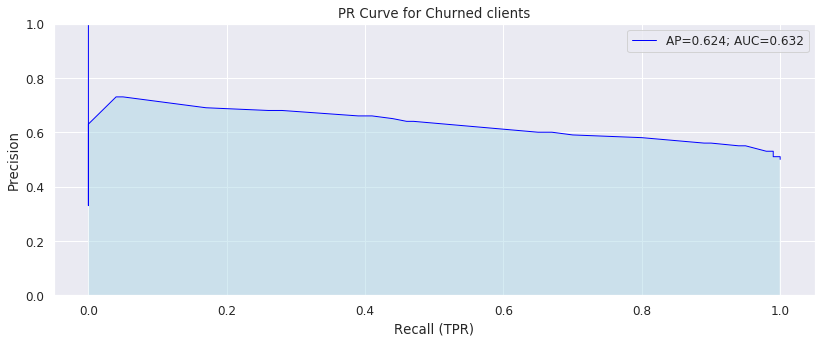

In [36]:
fig = plt.figure(figsize = (30,5))
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, clf_tree.predict_proba(X_test)[:,1], pos_label=1)
precision, recall = np.round(precision, 2), np.round(recall, 2)
# average precision score
avg_precision = average_precision_score(y_test, clf_tree.predict_proba(X_test)[:,1],pos_label=1)
# precision auc
pr_auc = auc(recall, precision)

ax1 = plt.subplot(121)
ax1.plot(recall, precision, lw=1, color='blue', label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
plt.fill_between(recall, precision,-1, facecolor='lightblue', alpha=0.5)
plt.xlabel('Recall (TPR)')
plt.ylim(0,1)

plt.ylabel('Precision')
plt.legend(loc="best")
plt.title('PR Curve for Churned clients');


## 2D

<b>Your Head of Department finally clarifies, and says that your model will be used take 30% of population with highest chance of death in the next 6 months, for a checkup  with the doctor (The other 70% will just be schedule to have see a doctor in the near future.). How would you justify your model now? 

Please write down a sentence or two explaining why you picked that metric</b>

I chosed this metric because there is a very high price for False Negative case - it will cost somebodys life. So we don't want to risk.

We can optimize the recall and  decrease the risk of False Negative prediction

## 2E

**A couple of months in, the Head of Department also remembers that the new grant includes a clause specifying that the contract will be cancelled if the Hospital doesn't abide by the following: "For the patients over 60 , 3% of them (the ones with least probability of death in the next six months) should not be referred to a doctor."**

**How would you say that your model helps the hospital in abiding by this rule?**

**Please write down a sentence or two explaining why you picked that metric**

In this case we should use the True Negative Rate, which we can calculate as  (TN / TN + FP). THis metric will help